# Geopricing with atoti
In this notebook we will explore a pricing use case that combines machine learning algorithms and atoti.  

Through machine learning, we will be able to create clusters of stores depending on their local competition and current prices.  
We will then be able to simulate various pricing strategies with atoti.  

For the machine learning, we will need a set of input features for each store:
- Number of competitors per distance range (1 KM, 5 KM, 10 KM etc)
- Price Index per store against its competitors

We will see how we can make use of simulation to create different data input for the machine learning.
We will then take the output from the machine learning to run different simulations:
- Pricing simulations around clusters
- Selling price simulation by clusters and stores

### Dependencies
Let's start by installing the libraries required for this notebook to work.

In [1]:
import sys

!conda install --yes --prefix {sys.prefix} folium scipy scikit-learn matplotlib seaborn

Solving environment: ...working... done

# All requested packages already installed.



In [2]:
import atoti as tt
import pandas as pd

Welcome to atoti 0.4.1!

By using this community edition, you agree with the license available at https://www.atoti.io/eula.
Browse the official documentation at https://docs.atoti.io.
Join the community at https://www.atoti.io/register.

You can hide this message by setting the ATOTI_HIDE_EULA_MESSAGE environment variable to True.


## Computing stores features

### Data preparation
We will first start by loading our stores into Pandas dataframe.

In [3]:
stores_df = pd.read_csv(
    "https://data.atoti.io/notebooks/geopricing/stores.csv", sep=";"
)
stores_df.head(5)

,StoreId,StoreName,Adress,ZipCode,City,Country,Latitude,Longitude,Company
0,1,ActiveViam Store Paris 1er,Paris 1er,75001,Paris,France,48.860757,2.342566,ActiveViam
1,2,ActiveViam Store Paris 15,Paris 15,75015,Paris,France,48.840412,2.312649,ActiveViam
2,3,ActiveViam Store Paris 18,Paris 18,75018,Paris,France,48.886483,2.344326,ActiveViam
3,4,ActiveViam Store Paris 12,Paris 12,75012,Paris,France,48.832182,2.375729,ActiveViam
4,5,ActiveViam Store Paris 16,Paris 16,75016,Paris,France,48.855454,2.280886,ActiveViam


And then those of the competitors.

In [4]:
competitor_stores_df = pd.read_csv(
    "https://data.atoti.io/notebooks/geopricing/competitor_stores.csv", sep=";"
)
competitor_stores_df.head(5)

,CompetitorStoreId,CompetitorStoreName,CompetitorStoreAdress,CompetitorStoreZipCode,CompetitorStoreCity,CompetitorStoreCountry,CompetitorStoreLatitude,CompetitorStoreLongitude,CompetitorStoreCompany
0,101,Concurrent Premium,Paris 1er,75001,Paris,France,48.860757,2.342566,Concurrent Premium
1,102,Concurrent Premium,Paris 15,75015,Paris,France,48.840412,2.312649,Concurrent Premium
2,103,Concurrent Premium,Paris 18,75018,Paris,France,48.886483,2.344326,Concurrent Premium
3,104,Concurrent Premium,Paris 12,75012,Paris,France,48.832182,2.375729,Concurrent Premium
4,105,Concurrent Premium,Paris 16,75016,Paris,France,48.855454,2.280886,Concurrent Premium


We can already visualize on a map our stores (in red) and those of the competition (in blue).

In [5]:
from utils import geo_utils

In [6]:
stores_map = geo_utils.build_stores_map(competitor_stores_df, stores_df)
stores_map

To assess whether a store has strong competition or not, we will count how many competitor stores there are within an area of radius 1km, 5km, 10km and 20km.  
In order to to that, we first need to compute distances between stores then count the number of competitor stores for each of the kilometers values above.

#### Computing distances between stores
To compute distances between stores, we simply used the [harvesine formula](https://en.wikipedia.org/wiki/Haversine_formula). Note that another approach would be to use instead something like the [google API to compute distances and durations between two points](https://developers.google.com/maps/documentation/distance-matrix/intro) (thus taking into accounts possible means of transportation).

First we build a matrix containing the distances between stores and all competitors.

In [7]:
stores_distances_matrix = geo_utils.create_stores_distances_matrix(
    stores_df, competitor_stores_df
)

stores_distances_matrix.head()

,CompetitorStoreId,StoreId,Competitor distance KM
0,101,1,0.000000
1,101,2,3.145965
2,101,3,2.861697
3,101,4,3.995581
4,101,5,4.547896


Next we proceed to load data into our stores for the data cube.

#### Data loading and cube creation
We begin by creating an atoti session.

In [8]:
session = tt.create_session()

We load the distance matrix into a data store. This will facilitate the computation of the number of competitors per area radius.  
Though not implemented in this notebook, we can also use it for analysis of price index against the competitors within a distance range.

In [9]:
distance_matrix = session.read_pandas(
    stores_distances_matrix,
    keys=["StoreId", "CompetitorStoreId"],
    store_name="DistanceMatrix",
    types={"StoreId": tt.types.INT, "CompetitorStoreId": tt.types.INT,},
)

distance_matrix.head()

,,Competitor distance KM
StoreId,CompetitorStoreId,
1.0,101.0,0.000000
2.0,101.0,3.145965
3.0,101.0,2.861697
4.0,101.0,3.995581
5.0,101.0,4.547896


Normally, we can have the selling price, cost price and quantity of the product sold. Margin hence can be derived, and we can consequently see the impact on margin when price index changes.  
In this notebook however, we simplify the use case by having only the SellingPrice and the total Margin for each product by stores.  

We multiply SellingPrice by Margin in the dataframe before loading it into atoti. This value will be used to compute the price index of the stores in the later section.  
It’s a good practice to do this kind of fact-level preprocessing outside atoti, as it avoids redoing these computations on every row over and over, slowing down every query.

In [10]:
#  We used pandas to read the selling price here as we will be using it again for price optimisation in the later section.
product_sales_df = pd.read_csv(
    "https://data.atoti.io/notebooks/geopricing/product_sales.csv"
)

product_sales_df["SellingPrice_x_Margin"] = (
    product_sales_df["SellingPrice"] * product_sales_df["Margin"]
)

In [11]:
productSales = session.read_pandas(
    product_sales_df,
    keys=["ProductId", "StoreId"],
    store_name="ProductSales",
    types={"ProductId": tt.types.INT, "StoreId": tt.types.INT},
)

productSales.head()

The store has been sampled because there are more than 10000 lines in the files to load. Call Session.load_all_data() to trigger the full load of the data.


SellingPrice    Margin  SellingPrice_x_Margin
ProductId StoreId                                               
4096.0    1.0             1.920  1959.530            3762.297600
          2.0             2.068  2204.228            4558.343504
          3.0             1.820  1835.545            3340.691900
          4.0             1.825  1641.052            2994.919900
          5.0             2.016  1307.136            2635.186176

In [12]:
price_index_cube = session.create_cube(productSales, "PriceIndexCube")

We will also require the competitors' product pricing against our stores.  
Due to the amount of data in this store, the store will be sampled by default. We will proceed to load all the data only after we are done modeling the cube.  
Note that atoti is able to load csv directly from s3.

In [13]:
competitorPrices = session.read_csv(
    "s3://data.atoti.io/notebooks/geopricing/competitor_prices.csv",
    keys=["ProductId", "CompetitorStoreId", "StoreId"],
    store_name="CompetitorPrices",
    types={
        "ProductId": tt.types.INT,
        "StoreId": tt.types.INT,
        "CompetitorStoreId": tt.types.INT,
    },
)

competitorPrices.head()

,,,CompetitorPrice
ProductId,CompetitorStoreId,StoreId,
4096.0,101.0,1.0,2.287
4097.0,101.0,1.0,2.320
4098.0,101.0,1.0,2.519
4099.0,101.0,1.0,2.504
4100.0,101.0,1.0,3.309


We have the key stores necessary for us to generate the data required for machine learning.  
However, we will also load the following stores that will allow us to have an in-depth analysis:
- Products: Product catalogue
- Stores: Store information such as location
- CompetitorsStores: Competitors' store information

In [14]:
products = session.read_csv(
    "s3://data.atoti.io/notebooks/geopricing/products_info.csv",
    sep=";",
    keys=["ProductId"],
    store_name="Products",
    types={"ProductId": tt.types.INT},
)

products.head()

,EAN,ProductName,Brand,Size,Unit,Department,SubDepartment,Category,SubCategory
ProductId,,,,,,,,,
4096,3124480000378,"1,5L CANADA DRY PET",CANADA DRY,1.5,L,LIQUIDES,SOFT TRADITIONNELS,TONIC,GINGER ALE
4097,3124480183927,"1,5L SCHWEPPES LEMON PET",SCHWEPPES,1.5,L,LIQUIDES,SOFT TRADITIONNELS,BOISSON AUX FRUITS GAZEUX,PET - PVC
4098,3124480183811,2L OASIS ORANGE PET,OASIS,2,L,LIQUIDES,SOFT TRADITIONNELS,BOISSON AUX FRUITS PLAT,PET - PVC
4099,3124480183828,2L OASIS TROPICAL PET,OASIS,2,L,LIQUIDES,SOFT TRADITIONNELS,BOISSON AUX FRUITS PLAT,PET - PVC
4100,3124480186577,6X33CL OASIS TROPICAL BT,OASIS,6x33,cl,LIQUIDES,SOFT TRADITIONNELS,BOISSON AUX FRUITS PLAT,BOITES


Previously we have loaded our stores and the competitors' store information into dataframes for the computation of the distance matrix.  
We will load the same dataframes into atoti store.

In [15]:
stores = session.read_pandas(
    stores_df,
    #     sep=";",
    keys=["StoreId"],
    store_name="Stores",
    types={"StoreId": tt.types.INT},
)

stores.head()

,StoreName,Adress,ZipCode,City,Country,Latitude,Longitude,Company
StoreId,,,,,,,,
1,ActiveViam Store Paris 1er,Paris 1er,75001,Paris,France,48.860757,2.342566,ActiveViam
2,ActiveViam Store Paris 15,Paris 15,75015,Paris,France,48.840412,2.312649,ActiveViam
3,ActiveViam Store Paris 18,Paris 18,75018,Paris,France,48.886483,2.344326,ActiveViam
4,ActiveViam Store Paris 12,Paris 12,75012,Paris,France,48.832182,2.375729,ActiveViam
5,ActiveViam Store Paris 16,Paris 16,75016,Paris,France,48.855454,2.280886,ActiveViam


In [16]:
competitorStore = session.read_pandas(
    competitor_stores_df,
    #     sep=";",
    keys=["CompetitorStoreId"],
    store_name="CompetitorsStores",
    types={"CompetitorStoreId": tt.types.INT},
)

competitorStore.head()

,CompetitorStoreName,CompetitorStoreAdress,CompetitorStoreZipCode,CompetitorStoreCity,CompetitorStoreCountry,CompetitorStoreLatitude,CompetitorStoreLongitude,CompetitorStoreCompany
CompetitorStoreId,,,,,,,,
101,Concurrent Premium,Paris 1er,75001,Paris,France,48.860757,2.342566,Concurrent Premium
102,Concurrent Premium,Paris 15,75015,Paris,France,48.840412,2.312649,Concurrent Premium
103,Concurrent Premium,Paris 18,75018,Paris,France,48.886483,2.344326,Concurrent Premium
104,Concurrent Premium,Paris 12,75012,Paris,France,48.832182,2.375729,Concurrent Premium
105,Concurrent Premium,Paris 16,75016,Paris,France,48.855454,2.280886,Concurrent Premium


_ProductSales_ will be our base store as we want to be able to see all the products available in our stores.  
Competitors may or may not have the same products as our product catalogue. We are only interested in the products that we are also selling.  
Hence we will join the _CompetitorPrices_ store to our _ProductSales_ store by _ProductId_ and _StoreId_.

In [17]:
productSales.join(
    competitorPrices, mapping={"ProductId": "ProductId", "StoreId": "StoreId"}
)

To have more efficient joins, we join the _Products_ and _Stores_ to the base store since this is the most direct reference. 

In [18]:
productSales.join(products, mapping={"ProductId": "ProductId"})
productSales.join(stores, mapping={"StoreId": "StoreId"})

As _CompetitorPrices_ store is more granular than the _CompetitorStore_, we join the latter to _CompetitorPrices_.

In [19]:
competitorPrices.join(
    competitorStore, mapping={"CompetitorStoreId": "CompetitorStoreId"}
)

_DistanceMatrix_ contains both the _StoreId_ and _CompetitorStoreId_.  \
As _CompetitorPrices_ store is already joined to the _ProductSales_ store which contains the _StoreId_.  \
By joining _DistanceMatrix_ to the _CompetitorPrices_, the _DistanceMatrix_ store automatically get linked to the _ProductSales_ store.

In [20]:
competitorPrices.join(
    distance_matrix,
    mapping={"CompetitorStoreId": "CompetitorStoreId", "StoreId": "StoreId"},
)

Let's see the final design of our cube.

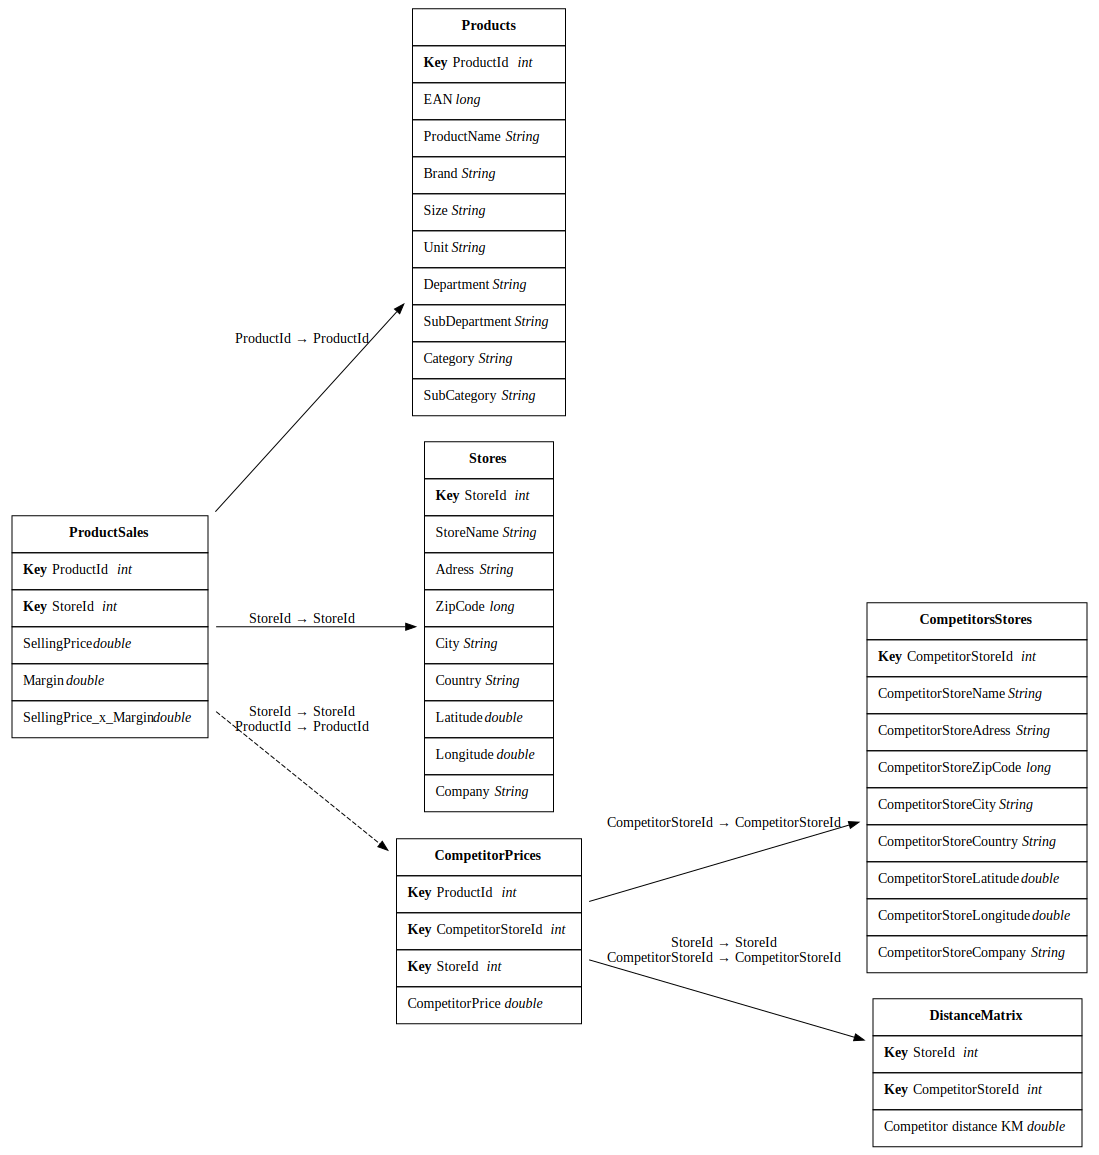

In [21]:
price_index_cube.schema

In [22]:
h = price_index_cube.hierarchies
m = price_index_cube.measures
lvl = price_index_cube.levels

In [23]:
m

Measures()

We can see a _SUM_ and _MEAN_ measure is created columns of type double/float for the base store - _ProductSales_.  \
A _VALUE_ measure is created for columns of type double/float in the other referenced stores.  

With the cube created, let's start by computing the price index per store.

### 1. Computing the price index per store

There are different existing formulas for the price index but the idea behind is always the same: the price index is a measurement of where a retailer is positioned compared to one or multiple of its competitors.

The formula we will use in this example compares a product price to the average price found among the local competitors of a particular store, measuring at which percentage of this average competitors price the product is.

We will weight the price index indicator by the margin when aggregating above store and product level. This is so that we can later optimize the price index for products that contribute the most to the margin. Other commonly used formulas weight by sales quantity or revenue.

#### Price index formula:

# $100 \times \frac{\sum_{s,p \in (Stores,Products)}\frac{Selling Price(s,p)}{Average Competitor Price(s,p)} \times Margin(s,p)}{\sum_{s,p \in (Stores,Products)}Margin(s,p)}$  

Let's create a measure to get the mean of _CompetitorPrice_ which will be used to derive the price index.

In [24]:
m["CompetitorPrice.MEAN"] = tt.agg.mean(competitorPrices["CompetitorPrice"])

We see how the weight price index indicator can be achieved in the next few cells.  
Realize how we are setting the scope on _ProductId_ and _StoreId_? This will ensure the summation of the various measures at the _Store_ and _Product_ level as required by the formula.

# ${\sum_{s,p \in (Stores,Products)}\frac{Selling Price(s,p)}{Average Competitor Price(s,p)} \times Margin(s,p)}$

In [25]:
price_index_numerator = tt.agg.sum(
    m["SellingPrice_x_Margin.SUM"] / m["CompetitorPrice.MEAN"],
    scope=tt.scope.origin(lvl["ProductId"], lvl["StoreId"]),
)

Finally, we calculate the contribution of the product towards the total margin.

In [26]:
m["Price Index"] = price_index_numerator / m["Margin.SUM"]

We can now have the price index per store and product.  
As we are currently in sampling mode, let's trigger full data load to do some visualizations.

In [27]:
session.load_all_data()

Let's visualize the price index per store.

In [29]:
price_index_cube.visualize()

Install and enable the atoti JupyterLab extension to see this widget.

### 2. Computing number of Competitors per Distance Bucket  

There are many ways to do compute the number of competitors per distance buckets. However, we are going to showcase how we can make use of the [`single_value`](https://docs.atoti.io/0.4.1/lib/atoti.html?highlight=single_value#atoti.agg.single_value) function and simulations to create the distance buckets.  

`single_value` returns a measure equal to the single value aggregation of the passed measure across the specified scope.  

The _DistanceMatrix_ store is linked to the _CompetitorsPrice_ store. As such, we need to ensure that we are looking at the same distance radius across all the products.  
`single_value` expects a measure input. So let's create a measure of static value 1 as input for `m["Threshold"]` (the maximum radius for the area we are going to look at).  
Similarly, we use `single_value` for `m["Distance]` to ensure that we do not sum up the competitor's distance across the products. 

In [29]:
m["1"] = 1
m["Threshold"] = tt.agg.single_value(m["1"], scope=tt.scope.origin(lvl["ProductId"]))

m["Distance"] = tt.agg.single_value(
    m["Competitor distance KM.VALUE"], scope=tt.scope.origin(lvl["ProductId"])
)

Due to the join to the _CompetitorsPrice_ store, the `m["Contributor.COUNT]` returned is based on the products.
We want to obtain the number of distinct competitors' stores that sell the same products as us, not the number of products.  

In [30]:
m["Nr Competitors"] = tt.agg.single_value(
    tt.agg.count_distinct(competitorPrices["CompetitorStoreId"]),
    scope=tt.scope.origin(lvl["ProductId"]),
)

We can now use the `where` condition to return the number of competitors who within our threshold radius.

In [31]:
m["Distance<Thresh"] = tt.agg.single_value(
    tt.where(m["Distance"] < m["Threshold"], m["Nr Competitors"], 0),
    scope=tt.scope.origin(lvl["ProductId"]),
)
m["Competitors<Thresh"] = tt.agg.sum(
    m["Distance<Thresh"], scope=tt.scope.origin(lvl["CompetitorStoreId"])
)

Naturally we can quickly use Pandas to derive the same value. However, when we use this one time setup together with simulations, we have the below benefits:
- easily add / delete the distance buckets
- ability to drill down on the data for each distance range to perform further analysis

#### Setting up simulation for distance buckets
We setup a simulation where we can replace the threshold value in order to be able to create scenarios for other ranges of distance.  
We name this base scenario "1 KM".

In [32]:
simulation = price_index_cube.setup_simulation(
    "Distance Simulation", base_scenario="1 KM", replace=[m["Threshold"]]
)

We can now easily obtain the number of competitors per area simply by creating a scenario for each distance radius.  
Let's start with the nearby competitors.

In [33]:
simulation.scenarios["5 KM"] = 5
simulation.scenarios["10 KM"] = 10

Let's do a quick data-viz to see how the number of competitors varies by the distance.

In [35]:
price_index_cube.visualize("Nr of competitors stacked by distance bucket")

Install and enable the atoti JupyterLab extension to see this widget.

How do we systematically make use of this information?  
We can use a machine algorithm such as k-means to make clusters with the features (1 KM, 5KM, 10KM, Price Index) that we can obtain from the cube.

### Outputting data for machine learning

We create a function queries the price index and the number of competitors per area for each store.   
It will return the dataset required for the machine learning.

In [36]:
def get_features():
    # output dataframe for competitors count per area from cube querying
    stores_competitors_count_per_area = price_index_cube.query(
        m["Competitors<Thresh"], levels=[lvl["StoreId"], lvl["Distance Simulation"]],
    ).reset_index()

    # pivot the table such that each scenario becomes a column
    stores_competitors_count_per_area = stores_competitors_count_per_area.pivot(
        index="StoreId", columns="Distance Simulation", values="Competitors<Thresh"
    )

    # output dataframe for price index by store from cube querying
    price_index_per_store = price_index_cube.query(
        m["Price Index"], levels=[lvl["StoreId"]]
    ).reset_index()

    # merge the 2 dataframe and return the output
    stores_features = pd.merge(
        stores_competitors_count_per_area,
        price_index_per_store,
        left_on="StoreId",
        right_on="StoreId",
        how="left",
    ).set_index("StoreId")

    return stores_features

In [37]:
stores_features = get_features()
stores_features.head()

,1 KM,10 KM,5 KM,Price Index
StoreId,,,,
1,11,66,51,0.986389
2,5,61,46,1.043176
3,5,71,36,0.960006
4,5,61,31,0.969073
5,5,56,36,1.030924


## ML - Stores clustering using price index and competitors number features

In this part we will use the previously calculated features (nr of competitor stores and price index) to generate 5 clusters of stores.  
We will now use those clusters to generate new prices and assess whether we have managed to improve our pricing.

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sc
import seaborn as sns
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import pairwise_distances_argmin

sns.set()  # for plot styling

We create an function to run the machine learning algorithm.

In [39]:
def run_algorithm(number_of_clusters, features_df):
    kmeans = MiniBatchKMeans(number_of_clusters)
    kmeans.fit(features_df)
    new_colors = kmeans.cluster_centers_[kmeans.predict(features_df)]
    k_means_labels = pairwise_distances_argmin(features_df, kmeans.cluster_centers_)
    labels = KMeans(number_of_clusters, random_state=0).fit_predict(features_df)

    return k_means_labels, labels

Let's set the number of clusters needed as 5. The number of clusters can increase if the number of outlets is huge.  
We pass in the _stores_features_ dataframe obtained from the cube to get the clustering details.

In [40]:
k_means_labels_1, labels_1 = run_algorithm(
    number_of_clusters=5, features_df=stores_features
)

Using competitors within 1km as an example, we can now analyze the result of the clustering by pair of features using matplotlib as shown below:

Text(0, 0.5, 'Price Index')

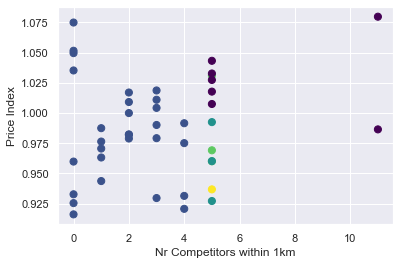

In [41]:
plt.scatter(
    stores_features.loc[:, "1 KM"],
    stores_features.loc[:, "Price Index"],
    c=k_means_labels_1,
    s=50,
    cmap="viridis",
)

plt.xlabel("Nr Competitors within 1km")
plt.ylabel("Price Index")

In the above plot, each color represents a cluster. We can see that clusters seem to be strongly based on the number of competitors rather than on the price index.  
However, to avoid having to plot every couple of features and understand more quickly what our clusters are, we will use seaborn to have a plot of the clustering result for every pair of features.

In [42]:
stores_features["Cluster"] = labels_1
stores_features.head(5)

,1 KM,10 KM,5 KM,Price Index,Cluster
StoreId,,,,,
1,11,66,51,0.986389,1
2,5,61,46,1.043176,1
3,5,71,36,0.960006,3
4,5,61,31,0.969073,3
5,5,56,36,1.030924,3


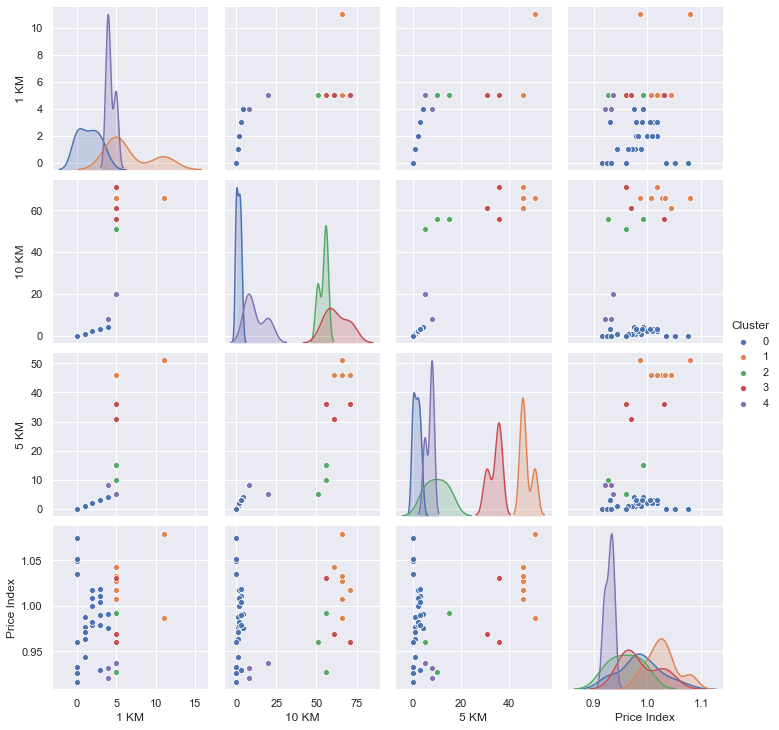

In [43]:
sns.pairplot(data=stores_features, hue="Cluster")

We can have a better understanding of the clusters with the chart above.  
For example majority of the stores below to cluster 0, having less than 5 competitors within 1km radius. This cluster generally has index pricing around 1.

Continuing this analysis tells us that:
- Cluster 0 has a even spread of price index around 1.0 and generally has few competitors in the neighbourhood.
- Cluster 1 is skewed towards a higher price index and has more competitors that are located further away.
- Cluster 2 is a small cluster that as few competitors nearby but number of competitors located within 10km increases tremendously.
- Cluster 3 is a small cluster that has a lower price index and has more competitors that are within 10km radius.
- Cluster 4 generally has little competitors around but the price index is also much lower.

## Pricing simulations around clusters
We will now generate new prices using the previous clusters in order to take into account the different competitiveness constraints of the stores.  

In [44]:
from utils import pricer

Using the clusters generated, the below pricing method tries to reduce the prices if the competitiveness is strong, and on the contrary increase it if there is few competition.  
For instance, cluster 0 and cluster 4 has little competition, hence their price index could be slightly higher than 1.  
The rest of the clusters have more competitors within 10km radius, hence could have their price index at 1 or slightly lower to maintain their competitivity.  

In [45]:
selling_prices_based_on_clusters = pricer.optimize_prices(
    product_sales_df, stores_features
)

Thanks to atoti built-in simulations capabilities, we can easily create a new scenario for the new pricing by directly loading the price-optimised dataframe.  
All the previously defined KPIs, e.g. the price index, will be re-computed on the fly, enabling us to compare the scenarios and their benefits.

In [46]:
productSales.scenarios["Selling Price Clustering 1"].load_pandas(
    selling_prices_based_on_clusters
)

In [48]:
price_index_cube.visualize()

Install and enable the atoti JupyterLab extension to see this widget.

Let's load the cluster results obtained from the machine learning model into the cube.

In [49]:
clusters_df = stores_features[["Cluster"]].reset_index()
clusters_df.StoreId = clusters_df.StoreId.astype("int32")
cluster_store = session.read_pandas(
    clusters_df, keys=["StoreId"], store_name="Clusters"
)

cluster_store.head(5)

,Cluster
StoreId,
1,1
2,1
3,3
4,3
5,3


In [50]:
stores.join(cluster_store)

With the cluster information added to the cube, we can now visualize the changes in price index for the 5 clusters.

In [52]:
price_index_cube.visualize("Price index optimisation difference")

Install and enable the atoti JupyterLab extension to see this widget.

We can see that the pricing method decreased the price index of stores in clusters that have high competition in order for them to attract more customers.  
On the contrary it increased the prices in stores belonging to low competition clusters in order to maximize margin.  
Cluster 1 and 4 for instance, have very few competitors. Hence their selling prices are adjusted higher, resulting in higher price index.

### Different data input for machine learning with distance buckets simulation

Depending on the location and type of environment, some people may be willing to go further to make their purchases.
Let's see how the clustering will change if we include a wider distance radius.
We will leverage on the simulation we created earlier on to add 2 distance buckets - 15km and 20km.

In [53]:
simulation.scenarios["15 KM"] = 15
simulation.scenarios["20 KM"] = 20

stores_features_2 = get_features()
stores_features_2.head()

,1 KM,10 KM,15 KM,20 KM,5 KM,Price Index
StoreId,,,,,,
1,11,66,71,71,51,0.986389
2,5,61,71,71,46,1.043176
3,5,71,71,71,36,0.960006
4,5,61,66,71,31,0.969073
5,5,56,71,71,36,1.030924


In [54]:
k_means_labels_2, labels_2 = run_algorithm(
    number_of_clusters=5, features_df=stores_features_2
)

In [55]:
stores_features_2["Cluster"] = labels_2
stores_features_2.head(5)

,1 KM,10 KM,15 KM,20 KM,5 KM,Price Index,Cluster
StoreId,,,,,,,
1,11,66,71,71,51,0.986389,2
2,5,61,71,71,46,1.043176,2
3,5,71,71,71,36,0.960006,2
4,5,61,66,71,31,0.969073,2
5,5,56,71,71,36,1.030924,2


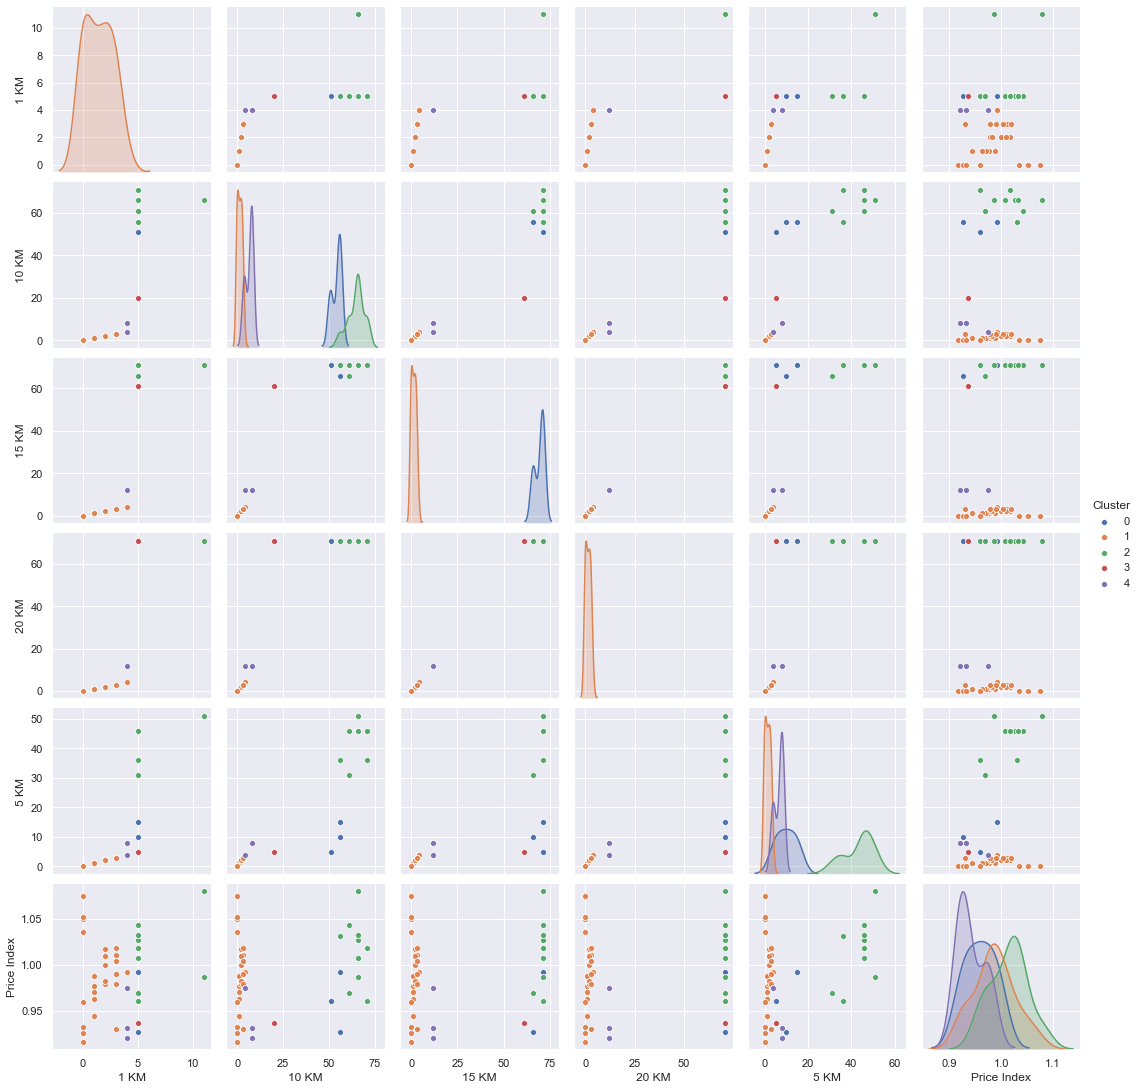

In [56]:
sns.pairplot(data=stores_features_2, hue="Cluster")

Compared to the initial distance buckets, the cluster size has changed.
- New cluster 0 is similar to the initial cluster 2: a small cluster that has slightly lower price index and most competitors are more than 10km away. 
- New cluster 1 is similar to the initial cluster 0: this is a big cluster with little competitors around.
- New cluster 2 is similar to the initial cluster 1: slight skewed towards a higher price index than the rest while the number of competitors are generally higher even within 5km distance radius.
- New cluster 3 becomes even smaller but the number of competitors increases tremendously as the distance radius increases.
- New cluster 4 price index is still much lower comparatively even though some of the stores has price index closer to 1. Number of competitors remains about the same across all buckets.

<img src="https://s3.eu-west-3.amazonaws.com/data.atoti.io/notebooks/geopricing/clustering1.png" alt="Clustering 1" style="width:600px;"/>

While this gives us an idea of how to position ourselves, we need to put these into context before we can decide on what pricing strategy to apply on it.  
Let's load the new cluster back into the cube to have more in-depth analysis.

In [57]:
new_clusters_df = stores_features_2[["Cluster"]].reset_index()
new_clusters_df.StoreId = new_clusters_df.StoreId.astype("int32")

cluster_store.scenarios["Clustering 2"].load_pandas(new_clusters_df)

We see how the distribution of the stores have changed after adding in 2 more distance buckets.

In [59]:
price_index_cube.visualize("Stores distribution across clusters before and after")

Install and enable the atoti JupyterLab extension to see this widget.

In [61]:
price_index_cube.visualize("Spread of clusters on map")

Install and enable the atoti JupyterLab extension to see this widget.

Interestingly, cluster 1 is distributed all over France except Paris, and mostly they are the only store in the neighbourhood that is under our retailer.  
Cluster 3 is a small cluster around Lille, the capital of the Hauts-de-France region in northern France.
The rest of the clusters have outlets under our retailer in close proximity, and most of them spread around Paris.  
The size of the points on the map reflects the number of competitors within 1km - we can see the competition around the city is the highest. 

In the case of cluster 1, the store is the only one under the retailer in the neighbour. The number of competitors is low, hence price index is less affected by competition.  
Rather, other factors such as variety of products, branding etc could take on a heavier factor on the price index - these are to be considered when applying a pricing strategy for this cluster. Generally, the price index could be higher.

For the rest of the clusters, there are a few considerations. Within the same proximity, their competitors of the stores are the same.  
Not only so, consumers can easily detect the price differences of products between the stores of the same retailer if they are close by one another.  
Hence it make more sense to align their price index and it should be slightly lower to push up its competitivity.

### Selling price simulation by clusters and stores

Let's apply a new pricing strategy on the new cluster groups. This time round, let's adjust the selling price by clusters instead.  
Just in case we need to trim the price index of certain stores within a cluster, we will include the _StoreId_ as a parameter for the simulation.

In [62]:
price_simulation = price_index_cube.setup_simulation(
    "Price simulation",
    base_scenario="Selling Price Initial",
    levels=[lvl["Cluster"], lvl["StoreId"]],
    multiply=[m["SellingPrice_x_Margin.SUM"]],
)

Thanks to atoti built-in simulations capabilities, we can easily create a new scenario for the new pricing by directly loading the price-optimised dataframe.  
All the previously defined KPIs, e.g. the price index, will be re-computed on the fly, enabling us to compare the scenarios and their benefits.

In [63]:
new_cluster_adjustment = price_simulation.scenarios["Selling Price New"]
new_cluster_adjustment.append(
    ("0", None, 1.0),
    ("1", None, 1.05),
    ("2", None, 0.95),
    ("3", None, 1.0),
    ("4", None, 1.05),
)

In [65]:
price_index_cube.visualize("Price index optimisation difference by scenario")

Install and enable the atoti JupyterLab extension to see this widget.

Among cluster 3, seems that the price index of the store ActiveViam Store Paris 16 (5) is slightly higher than the rest in its cluster.  
Let's try to adjust it so that its price index is slightly below 1.

In [66]:
new_cluster_adjustment.append(("3", "5", 0.95))

In [68]:
price_index_cube.visualize("Price simulation of store 5")

Install and enable the atoti JupyterLab extension to see this widget.

We saw how machine learning helps to identify the clusters based on the amount geographical competitions.  
With this information, we applied different pricing strategy to each cluster using simulations from atoti to understand the impact on the price index.
We also look within a cluster to adjust the pricing of a specific store so that it's more attuned to the pricing of the other stores in the cluster. 

With atoti, we can easily combine the simulations of various factors such as festivals, promotions, seasons etc.
If we have more data such as the quantity of products sold, we can easily see the differences in the margin with each pricing strategy.  
We can thereafter decide on the best pricing from the combination of simulations.

Do have a look at how we can strategize the price index around product class in the [pricing-simulations-around-product-classes](https://github.com/atoti/notebooks/tree/master/retail/pricing-simulations-around-product-classes) notebook and its [corresponding article](https://www.atoti.io/data-dive-how-to-improve-pricing-strategies-with-a-set-of-checkout-receipts/).  
Maybe you can have a go at combining the two strategies to get your own price index!